<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab  


</br>  
</br>  
*Authors:*
 - Joseph Nelson (DC)      
 - Boom Devahastin Na Ayudhya  (NYC)   
 - Bethany Poulin (Boston) 



---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import aic
import itertools
%matplotlib inline
from sklearn.metrics import  mean_squared_error
import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, format='%Y/%m/%d')

data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [2]:
Weekly_Sales = data[data['Store']==1].copy()
Weekly_Sales = Weekly_Sales.resample('W').sum()

#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

Text(0.5, 0, 'time')

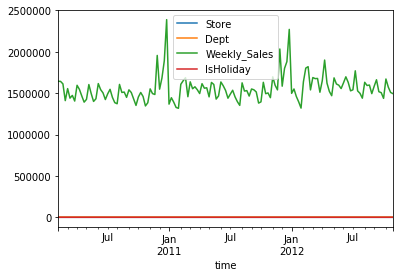

In [3]:
Weekly_Sales.plot()
plt.xlabel('time')

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

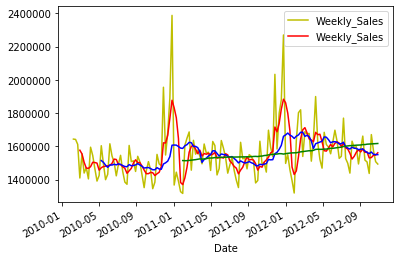

In [4]:
ax_delays = Weekly_Sales['Weekly_Sales'].plot(x_compat=True, color=['y'])
Weekly_Sales['Weekly_Sales'].rolling(4).mean().plot(color=['r'], ax=ax_delays, legend=0) 
Weekly_Sales['Weekly_Sales'].rolling(14).mean().plot(color=['b'], ax=ax_delays, legend=1) 
Weekly_Sales['Weekly_Sales'].rolling(52).mean().plot(color=['g'], ax=ax_delays, legend=2) 


**2c. What can you say about trends in the data based on the rolling mean plot above?**

The yearly rolling mean standardizes the fluctutations the most. The more rolling avergage we put in it, the more we achieve more conformity to a trend and less wild fluctuations.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [5]:
Weekly_Sales['lag_week']= Weekly_Sales['Weekly_Sales'].shift(1)
Weekly_Sales['lag_2_weeks'] = Weekly_Sales['Weekly_Sales'].shift(2)
Weekly_Sales['lag_year'] = Weekly_Sales['Weekly_Sales'].shift(52)

**3b. What can you say about the series based on these autocorrelations?**

The data will standardize into a trend over time

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

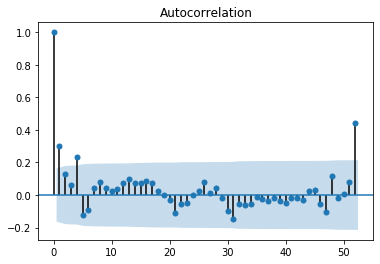

In [6]:
plot_acf(Weekly_Sales['Weekly_Sales'],lags = 52);

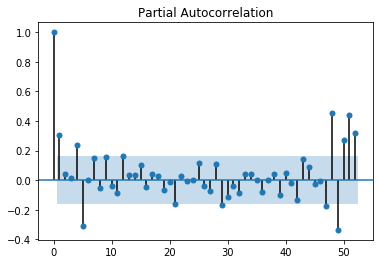

In [7]:
plot_pacf(Weekly_Sales['Weekly_Sales'],lags = 52);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

ACF = Correlation is large in the beginning and gets smaller so there exists a trend among the data.
PACF  = We have a lot of seasonality in the data. There exists seasonality and a clear trend as a large amount of lags are statistically significant. 

Yearly and monthly seasonality.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

We need to use ARIMA with a chosen p,d,q. We need to control for seasonality, and find the diff, lag in order to create an accurate model. 

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [8]:
Weekly_Sales.dropna(inplace=True)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(Weekly_Sales['lag_week'],
                                                    Weekly_Sales['Weekly_Sales'],
                                                    test_size = 0.25,
                                                    shuffle = False)



#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(68,)
(23,)
(68,)
(23,)


In [11]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(68, 2)
(23, 2)
(68,)
(23,)


In [12]:

y_train = y_train[X_train.index] 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(68, 2)
(23, 2)
(68,)
(23,)


In [13]:
ar1 = sm.OLS(y_train, X_train)
ar1_results = ar1.fit()

In [14]:
print(ar1_results.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     5.981
Date:                Mon, 18 May 2020   Prob (F-statistic):             0.0171
Time:                        09:16:24   Log-Likelihood:                -905.90
No. Observations:                  68   AIC:                             1816.
Df Residuals:                      66   BIC:                             1820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.136e+06   1.83e+05      6.209      0.0

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [15]:
print(f' Train MSE is {mean_squared_error(y_train, ar1_results.predict(X_train))}')
print(f' Test MSE is {mean_squared_error(y_test, ar1_results.predict(X_test))}')

 Train MSE is 21823345029.900993
 Test MSE is 7308484505.397349


**6c. How effective do you think this `AR(1)` model is?**

Its very bad.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.|

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

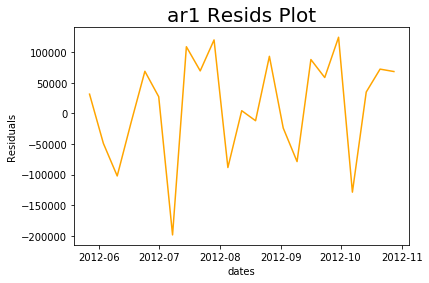

In [16]:
plt.plot(X_test.index, ar1_results.predict(X_test) - y_test, c = "orange")
plt.title("ar1 Resids Plot",{'fontsize': 20}# plotting ridge resids plot 
         )
plt.xlabel("dates")
plt.ylabel("Residuals")


plt.show()

**7b. What do the residual plots reveal about our model?**

It made a larger mistakes around the quarter and year mark.

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Weekly_Sales['lag_2_weeks'],
                                                    Weekly_Sales['Weekly_Sales'],
                                                    test_size = 0.25,
                                                    shuffle = False)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
ar2 = sm.OLS(y_train, X_train)
ar2_results = ar2.fit()
print(f' Train MSE is {mean_squared_error(y_train, ar2_results.predict(X_train))}')
print(f' Test MSE is {mean_squared_error(y_test, ar2_results.predict(X_test))}')

 Train MSE is 23364318063.77253
 Test MSE is 7507586454.126424


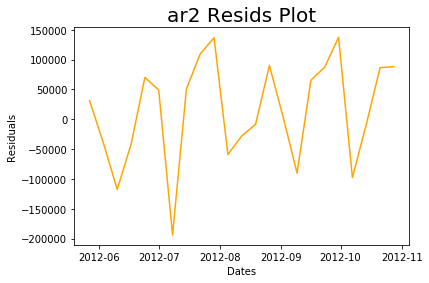

In [18]:
plt.plot(X_test.index, ar2_results.predict(X_test) - y_test, c = "orange")
plt.title("ar2 Resids Plot",{'fontsize': 20}# plotting ridge resids plot 
         )
plt.xlabel("Dates")
plt.ylabel("Residuals")


plt.show()

**8b. How did your results change?**

It stayed about the same

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [19]:
y_train, y_test = train_test_split(Weekly_Sales['Weekly_Sales'],
                                   test_size = 0.25,
                                   shuffle = False) # Shuffle = False is IMPORTANT!

y_test.shape

(23,)

In [20]:
arma = ARIMA(endog = y_train, order = (2, 0, 2))
# Fitting AR(1) model
arma_results = arma.fit()

In [21]:
preds = arma_results.predict(start = Weekly_Sales['Weekly_Sales'].index[0], end= Weekly_Sales['Weekly_Sales'].index[-1])


In [22]:
data = Weekly_Sales['Weekly_Sales']

In [23]:
print(f' Test MSE is {mean_squared_error(data,preds)}')


 Test MSE is 17793778962.973072


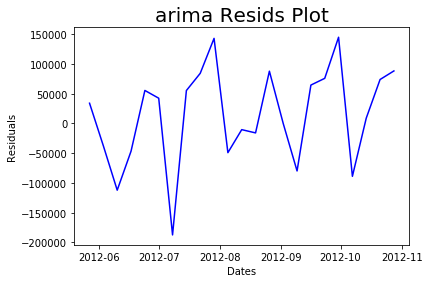

In [24]:
plt.plot(data.index, preds - y_test, c = "blue")
plt.title("arima Resids Plot",{'fontsize': 20}# plotting ridge resids plot 
         )
plt.xlabel("Dates")
plt.ylabel("Residuals")


plt.show()

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



They stay about the same

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [25]:
(adfuller(Weekly_Sales['Weekly_Sales'].dropna()))

(-2.7072516205621744,
 0.07279180625050863,
 6,
 84,
 {'1%': -3.510711795769895,
  '5%': -2.8966159448223734,
  '10%': -2.5854823866213152},
 2071.698954257466)

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

In [26]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [27]:
interpret_dftest((adfuller(Weekly_Sales['Weekly_Sales'])))

Test Statistic   -2.707252
p-value           0.072792
dtype: float64

We need to to diff to get stationarity

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [28]:
Weekly_Sales['Weekly_Sales_firs_diff'] = Weekly_Sales['Weekly_Sales'].diff(1)
Weekly_Sales['Weekly_Sales_sec_diff'] = Weekly_Sales['Weekly_Sales'].diff(1).diff(1)
Weekly_Sales['Weekly_Sales_third_diff'] = Weekly_Sales['Weekly_Sales'].diff(1).diff(1).diff(1)
Weekly_Sales['Weekly_Sales_fourth_diff'] = Weekly_Sales['Weekly_Sales'].diff(1).diff(1).diff(1).diff(1)

In [29]:
Weekly_Sales.head()

,Store,Dept,Weekly_Sales,IsHoliday,lag_week,lag_2_weeks,lag_year,Weekly_Sales_firs_diff,Weekly_Sales_sec_diff,Weekly_Sales_third_diff,Weekly_Sales_fourth_diff
Date,,,,,,,,,,,
2011-02-06,71,3137,1606629.58,0.0,1316899.31,1327405.42,1643690.90,NaN,NaN,NaN,NaN
2011-02-13,72,3182,1649614.93,72.0,1606629.58,1316899.31,1641957.44,42985.35,NaN,NaN,NaN
2011-02-20,72,3182,1686842.78,0.0,1649614.93,1606629.58,1611968.17,37227.85,-5757.50,NaN,NaN
2011-02-27,72,3182,1456800.28,0.0,1686842.78,1649614.93,1409727.59,-230042.50,-267270.35,-261512.85,NaN
2011-03-06,73,3281,1636263.41,0.0,1456800.28,1686842.78,1554806.68,179463.13,409505.63,676775.98,938288.83


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [30]:
interpret_dftest(adfuller(Weekly_Sales['Weekly_Sales_firs_diff'].dropna()))

Test Statistic   -5.766885e+00
p-value           5.506297e-07
dtype: float64

In [31]:
interpret_dftest(adfuller(Weekly_Sales['Weekly_Sales_sec_diff'].dropna()))

Test Statistic   -7.075589e+00
p-value           4.811481e-10
dtype: float64

In [32]:
interpret_dftest((adfuller(Weekly_Sales['Weekly_Sales_third_diff'].dropna())))

Test Statistic   -5.829217e+00
p-value           4.011735e-07
dtype: float64

In [33]:
interpret_dftest((adfuller(Weekly_Sales['Weekly_Sales_fourth_diff'].dropna())))

Test Statistic   -7.571893e+00
p-value           2.826929e-11
dtype: float64

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

The first one

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Yes, because we have seasonality and a clear trend in the data that we need to account for in predicting future values

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [34]:
y_train, y_test = train_test_split(Weekly_Sales['Weekly_Sales'],
                                   test_size = 0.25,
                                   shuffle = False) 


In [35]:
arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (2,0,2))

In [36]:
arima_results = arima.fit()

In [37]:
preds = arima_results.predict(start = Weekly_Sales['Weekly_Sales'].index[0], end= Weekly_Sales['Weekly_Sales'].index[-1])

In [38]:
print(f' Test MSE is {mean_squared_error(data,preds)}')

 Test MSE is 17793778962.973072


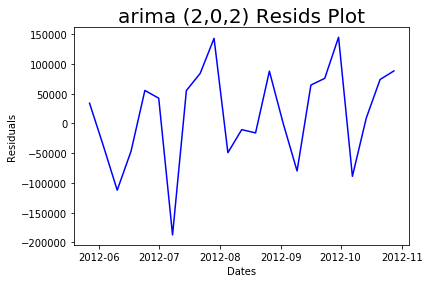

In [39]:
plt.plot(data.index, preds - y_test, c = "blue")
plt.title("arima (2,0,2) Resids Plot",{'fontsize': 20}# plotting ridge resids plot 
         )
plt.xlabel("Dates")
plt.ylabel("Residuals")


plt.show()


**11b. Interpret the results from the last answer.**


Its the same as the last one because the optimal I is 0.

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [47]:
y_train, y_test = train_test_split(Weekly_Sales['Weekly_Sales'],
                                   test_size = 0.25,
                                   shuffle = False) 

In [52]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_test,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1999214714427
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:274.36180976813733
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:271.7755375357823
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:293.6228186991609
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:269.79572449072896
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:647.7223999086112
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:279.4133842043334
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:241.4851245560913
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:340.0142100655569
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:281.284883064582
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:552.2613580390127
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:237.2286838082966
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:252.49145545762076
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:

In [56]:
mod = sm.tsa.statespace.SARIMAX(Weekly_Sales['Weekly_Sales'],
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarimax = mod.fit()


In [60]:
preds = sarimax.predict(start = Weekly_Sales['Weekly_Sales'].index[0], end= Weekly_Sales['Weekly_Sales'].index[-1])

In [67]:
data = Weekly_Sales['Weekly_Sales']
preds.shape

(91,)

In [68]:
print(f' Test MSE is {mean_squared_error(data,preds)}')

 Test MSE is 85917695354.33281


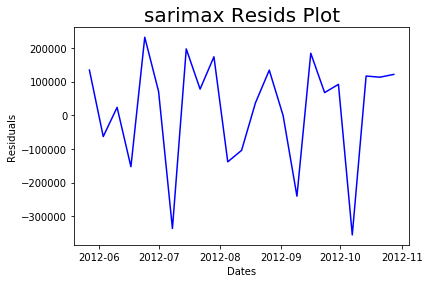

In [69]:
plt.plot(data.index, preds - y_test, c = "blue")
plt.title("sarimax Resids Plot",{'fontsize': 20}# plotting ridge resids plot 
         )
plt.xlabel("Dates")
plt.ylabel("Residuals")


plt.show()



**12b. How did your best SARIMAX model perform?**

It seems to be much more in line with the fluctuations of the data. And as it gets close to a year ot gets more accurate.

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

The ARIMA (2,0,2) had the lowest MSE.

In [45]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                   68
Model:                     ARMA(2, 2)   Log Likelihood                -905.453
Method:                       css-mle   S.D. of innovations         146642.887
Date:                Mon, 18 May 2020   AIC                           1822.906
Time:                        09:16:27   BIC                           1836.223
Sample:                    02-06-2011   HQIC                          1828.183
                         - 05-20-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.582e+06    2.9e+04     54.638      0.000    1.53e+06    1.64e+06
ar.L1.Weekly_Sales     0.7208      1.458      0.495      0.621      -2.136       3.578
ar.L2.Weekly_Sales    -0.0401      0.799     -0.050      0.960      -1.606       1.526
ma.L1.Weekly_Sales    -0.4533      1.452     -0.312      0.755      -3.299       2.392
ma.L2.Weekly_Sales    -0.0189      0.448     -0.042      0.966      -0.897       0.860
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5149           +0.0000j            1.5149            0.0000
AR.2           16.4781           +0.0000j           16.4781            0.0000
MA.1            2.0336           +0.0000j            2.0336            0.0000
MA.2          -26.0302           +0.0000j           26.0302            0.5000
-----------------------------------------------------------------------------
"""

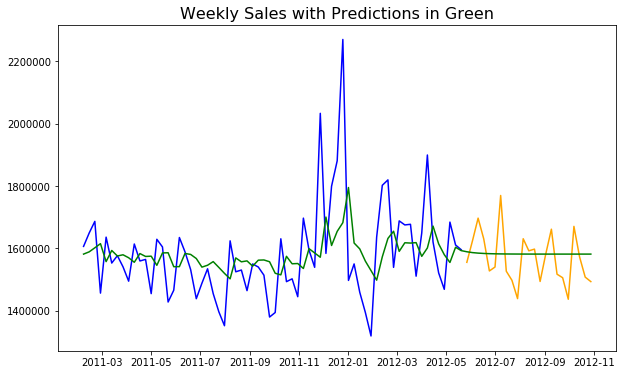

In [46]:
arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (2,0,2))
# Fit ARIMA model.
arima_results = arima.fit()

# Generate predictions based on test set.
preds = arima_results.predict(start = Weekly_Sales['Weekly_Sales'].index[0], end= Weekly_Sales['Weekly_Sales'].index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(data.index, preds, color = 'green')

plt.title(label = 'Weekly Sales with Predictions in Green', fontsize=16)
plt.show();

**13b. How does our model perform at predicting weekly sales moving forward?** 

It doesn't do a good job at predicting the fluctuations but it can anticipate the general trend.

**13c. How might you improve it?**

More years of data could help.

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: